## ***Short Guideline***


*   All models Should be on the same directory with this notebook (download weights from [here](https://drive.google.com/drive/folders/1uHCh6ZOAmB6qULURklHse_CuoU-NpaQU?usp=sharing))
*   Images should be located inside a folder named (**images**) which is **inside** a data folder.
*   **Data** folder should include folders(**queries, databases**) and **queries_scenarios.csv** (same structure for the submission environment)
*   The notebook will generate multiple directories:
1.  First one is the **heatmap** folder which will include the heatmaps for each model and TTA. Each heatmap will be named according to the corresponding model/TTA keeping the original image name.
2.  **Submission** folder that includes the CSV submission file
3.  **Results** folder will have a full visualization for each (**top/ top** pair) between each query and its match as shown on the image below.
4.  **Results_literal** folder will have a full visualization for each (**literal/ top** or **top/literal** pair) between each query and its match 




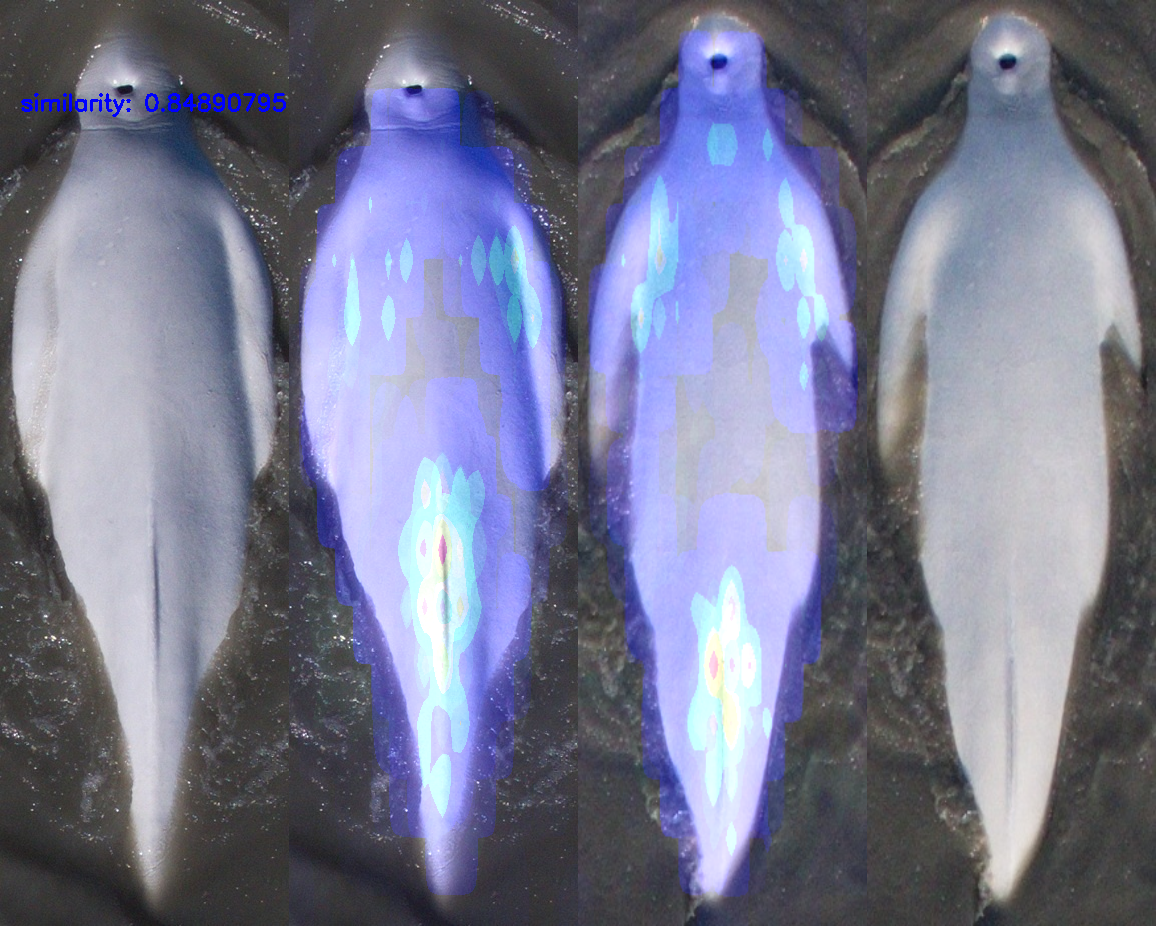

## ***Make Directories***

In [ ]:
import os 
if not os.path.exists("submission"):
    os.makedirs("submission")
if not os.path.exists("heatmap"):
    os.makedirs("heatmap")
if not os.path.exists("results"):
    os.makedirs("results")
if not os.path.exists("results_literal"):
    os.makedirs("results_literal")

## ***Main Part (inference)***

In [ ]:
import sys 
from tqdm import tqdm
import math
import random
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import torch
import timm
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics.pairwise import cosine_similarity
import gc
#ROOT_DIRECTORY = Path("/code_execution")
ROOT_DIRECTORY = Path("./")
PREDICTION_FILE = ROOT_DIRECTORY / "submission" / "submission.csv"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"

class CFG:
    DIM = (512,512)
    NUM_WORKERS = 4
    TRAIN_BATCH_SIZE = 8
    VALID_BATCH_SIZE = 8
    EPOCHS = 20
    SEED = 42
    device = torch.device('cuda')
    model_name = 'tf_efficientnet_b2_ns'
    loss_module = 'arcface' #'cosface' #'adacos'
    s = 30.0
    m = 0.5 
    ls_eps = 0.0
    easy_margin = False
    scheduler_params = {
          "lr_start": 1e-5,
          "lr_max": 5e-4 ,
          "lr_min": 5e-6,
          "lr_ramp_ep": 15,
          "lr_sus_ep": 0,
          "lr_decay": 0.8,
      }
    model_params = {
      'n_classes':788,
      'model_name':'tf_efficientnet_b5_ns',
      'use_fc':False,
      'fc_dim':2048,
      'dropout':0.0,
      'loss_module':loss_module,
      's':30.0,
      'margin':0.50,
      'ls_eps':0.0,
      'theta_zero':0.785,
      'pretrained':False
    }
    model_params2 = {
      'n_classes':788,
      'model_name':'efficientnetv2_rw_m',
      'use_fc':False,
      'fc_dim':2048,
      'dropout':0.0,
      'loss_module':loss_module,
      's':30.0,
      'margin':0.50,
      'ls_eps':0.0,
      'theta_zero':0.785,
      'pretrained':False
    }

def get_valid_transforms():

    return albumentations.Compose(
        [
            albumentations.Resize(CFG.DIM[0],CFG.DIM[1],always_apply=True),
            albumentations.Normalize(),
        ToTensorV2(p=1.0)
        ]
    )

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

class WhaleDataset_testing(Dataset):
    def __init__(self, csv, transforms=None):

        self.csv = csv
        self.augmentations = transforms

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        
        image = cv2.imread('data/' + row.path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img = cv2.imread('data/' + row.path)
        if img.shape[0] < img.shape[1]:
            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        image2 = np.fliplr(image)
        image3 = image.copy()
        if image.shape[0] < image.shape[1]:
            image3 = cv2.rotate(image3, cv2.ROTATE_90_CLOCKWISE)
        image4 = np.fliplr(image3)
        if self.augmentations:
            augmented = self.augmentations(image=image)
            image = augmented['image']       
            augmented = self.augmentations(image=image2)
            image2 = augmented['image']
            augmented = self.augmentations(image=image3)
            image3 = augmented['image']
            augmented = self.augmentations(image=image4)
            image4 = augmented['image']
        
        return {"image_id": self.csv.index[index], "image": image3, "image2": image4, "image3": image3, "image4": image4, "image_unchanged":img}

    

def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)

    return output
class ElasticArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.50,std=0.0125,plus=False):
        super(ElasticArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)
        self.std=std
        self.plus=plus
    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis=1)
        kernel_norm = l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(label != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1], device=cos_theta.device)
        margin = torch.normal(mean=self.m, std=self.std, size=label[index, None].size(), device=cos_theta.device) # Fast converge .clamp(self.m-self.std, self.m+self.std)
        if self.plus:
            with torch.no_grad():
                distmat = cos_theta[index, label.view(-1)].detach().clone()
                _, idicate_cosie = torch.sort(distmat, dim=0, descending=True)
                margin, _ = torch.sort(margin, dim=0)
            m_hot.scatter_(1, label[index, None], margin[idicate_cosie])
        else:
            m_hot.scatter_(1, label[index, None], margin)
        cos_theta.acos_()
        cos_theta[index] += m_hot
        cos_theta.cos_().mul_(self.s)
        return cos_theta
    
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

class WhaleNet_testing(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 loss_module='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=False):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(WhaleNet_testing, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  GeM()#nn.AdaptiveAvgPool2d(1)
        self.bn = nn.BatchNorm1d(6144)
        self.ln = nn.Linear(6144, final_in_features)
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ElasticArcFace(final_in_features, n_classes,
                                          s=s, m=margin)#, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature, featurs2 = self.extract_feat(x)
        return feature, featurs2

    def extract_feat(self, x):
        batch_size = x.shape[0]
        xx = self.backbone(x)
        x1 = self.pooling(xx).view(batch_size, -1)
        x2 = self.pooling(xx).view(batch_size, -1)
        x3 = self.pooling(xx).view(batch_size, -1)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.bn(x)
        x = self.ln(x)
        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)

        return x, xx

class WhaleNet_Eff_v2(nn.Module):

    def __init__(self,
                 n_classes,
                 model_name='efficientnet_b0',
                 use_fc=False,
                 fc_dim=512,
                 dropout=0.0,
                 loss_module='softmax',
                 s=30.0,
                 margin=0.50,
                 ls_eps=0.0,
                 theta_zero=0.785,
                 pretrained=False):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        :param pooling: One of ('SPoC', 'MAC', 'RMAC', 'GeM', 'Rpool', 'Flatten', 'CompactBilinearPooling')
        :param loss_module: One of ('arcface', 'cosface', 'softmax')
        """
        super(WhaleNet_Eff_v2, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  GeM()#nn.AdaptiveAvgPool2d(1)
        self.bn = nn.BatchNorm1d(final_in_features)
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.bn = nn.BatchNorm1d(fc_dim)
            self.bn.bias.requires_grad_(False)
            self.fc = nn.Linear(final_in_features, n_classes, bias = False)            
            self.bn.apply(weights_init_kaiming)
            self.fc.apply(weights_init_classifier)
            #self._init_params()
            final_in_features = fc_dim

        self.loss_module = loss_module
        if loss_module == 'arcface':
            self.final = ElasticArcFace(final_in_features, n_classes,
                                          s=s, m=margin)#, easy_margin=False, ls_eps=ls_eps)
        elif loss_module == 'cosface':
            self.final = AddMarginProduct(final_in_features, n_classes, s=s, m=margin)
        elif loss_module == 'adacos':
            self.final = AdaCos(final_in_features, n_classes, m=margin, theta_zero=theta_zero)
        else:
            self.final = nn.Linear(final_in_features, n_classes)

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature, features2 = self.extract_feat(x)
        return feature, features2

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x1 = self.backbone(x)
        x = self.pooling(x1).view(batch_size, -1)
        x = self.bn(x)
        if self.use_fc:
            x1 = self.dropout(x)
            x1 = self.bn(x1)
            x1 = self.fc(x1)
        return x, x1
    
    
#logger.info("Starting main script")
# load test set data and pretrained model
query_scenarios = pd.read_csv(DATA_DIRECTORY / "query_scenarios.csv", index_col="scenario_id")
metadata = pd.read_csv(DATA_DIRECTORY / "metadata.csv", index_col="image_id")
#logger.info("Loading pre-trained model")

# we'll only precompute embeddings for the images in the scenario files (rather than all images), so that the
# benchmark example can run quickly when doing local testing. this subsetting step is not necessary for an actual
# code submission since all the images in the test environment metadata also belong to a query or database.
scenario_imgs = []
for row in query_scenarios.itertuples():
    scenario_imgs.extend(pd.read_csv(DATA_DIRECTORY / row.queries_path).query_image_id.values)
    scenario_imgs.extend(pd.read_csv(DATA_DIRECTORY / row.database_path).database_image_id.values)
scenario_imgs = sorted(set(scenario_imgs))
metadata = metadata.loc[scenario_imgs]

# instantiate dataset/loader and generate embeddings for all images
test_dataset = WhaleDataset_testing(metadata, transforms=get_valid_transforms())
dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)
embeddings = []
embeddings_literal = []
embeddings_sameyear = []
embeddings_differentyears = []
embeddings_2017 = []
embeddings_2018 = []
embeddings_2019 = []
    
    
model6 = WhaleNet_Eff_v2(**CFG.model_params2)
state6 = torch.load("model_efficientnetv2_rw_m_IMG_SIZE_512_arcface_f0_7-05.bin",map_location=torch.device(CFG.device))
model6.load_state_dict(state6)
model6.to(CFG.device)
del state6
gc.collect()
torch.cuda.empty_cache()
        
model7 = WhaleNet_Eff_v2(**CFG.model_params2)
state7 = torch.load("model_efficientnetv2_rw_m_IMG_SIZE_512_arcface_f2_6-79.bin",map_location=torch.device(CFG.device))
model7.load_state_dict(state7)
model7.to(CFG.device)
del state7
gc.collect()
torch.cuda.empty_cache()

model8 = WhaleNet_Eff_v2(**CFG.model_params2)
state8 = torch.load("model_efficientnetv2_rw_m_IMG_SIZE_512_arcface_f4_6-99.bin",map_location=torch.device(CFG.device))
model8.load_state_dict(state8)
model8.to(CFG.device)
del state8
gc.collect()
torch.cuda.empty_cache() 
model6.eval()
model7.eval()
model8.eval()
embeddings2 = []
def extract(g):
    global features_grad
    features_grad = g

def generate_heatmap(feat, batch_embeddings1, img, name, dim):  
    feat.register_hook(extract) 
    batch_embeddings1.sum().backward()
    grads = features_grad # Get gradient
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))
    pooled_grads = pooled_grads[0]
    features = feat[0]
      # 512 is the number of channels in the last layer of feature
    for i in range(dim):
        features[i, ...] *= pooled_grads[i, ...]
    heatmap = features.detach().to('cpu').numpy()

    heatmap = np.mean(heatmap, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    superimposed_img = heatmap #* 0.7 + img # here 0.7 is the heat map intensity factor
    cv2.imwrite("heatmap/" + name +'_heat_map.png', superimposed_img)
    
def generate_heatmap_flip(feat, batch_embeddings1, img, name, dim):  
    feat.register_hook(extract) 
    batch_embeddings1.sum().backward()
    grads = features_grad # Get gradient
    pooled_grads = torch.nn.functional.adaptive_avg_pool2d(grads, (1, 1))
    pooled_grads = pooled_grads[0]
    features = feat[0]
      # 512 is the number of channels in the last layer of feature
    for i in range(dim):
        features[i, ...] *= pooled_grads[i, ...]
    heatmap = features.detach().to('cpu').numpy()

    heatmap = np.mean(heatmap, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Adjust the size of the heat map to be the same as the original image
    heatmap = np.uint8(255 * heatmap) # Convert the heat map to RGB format
    heatmap = np.fliplr(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the heat map to the original image
    superimposed_img = heatmap #* 0.7 + img # here 0.7 is the heat map intensity factor
    cv2.imwrite("heatmap/" + name +'_heat_map.png', superimposed_img)
    
for batch in tqdm(dataloader, total=len(dataloader),disable=True):
    batch_embeddings6, feat1 = model6(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model6(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings6, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model6", 2152)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model6_flip", 2152)
    batch_embeddings6 = ((batch_embeddings + batch_embeddings6) / 2).detach().cpu().numpy()
    
    batch_embeddings7, feat1 = model7(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model7(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings7, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model7", 2152)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model7_flip", 2152)
    batch_embeddings7 = ((batch_embeddings + batch_embeddings7) / 2).detach().cpu().numpy()
    
    batch_embeddings8, feat1 = model8(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model8(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings8, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model8", 2152)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model8_flip", 2152)
    batch_embeddings8 = ((batch_embeddings + batch_embeddings8) / 2).detach().cpu().numpy()
    
    batch_embeddings = np.concatenate((batch_embeddings6, batch_embeddings7, batch_embeddings8), 1)
    batch_embeddings_df = pd.DataFrame(batch_embeddings, index=batch["image_id"])
    embeddings2.append(batch_embeddings_df)
del model6, model7, model8  
gc.collect()
torch.cuda.empty_cache()
    
model1 = WhaleNet_testing(**CFG.model_params)
state1 = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_f2_6-76.bin",map_location=torch.device(CFG.device))
model1.load_state_dict(state1)
model1.to(CFG.device)
del state1
gc.collect()
torch.cuda.empty_cache()

model2 = WhaleNet_testing(**CFG.model_params)
state2 = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_f0_7-16.bin",map_location=torch.device(CFG.device))
model2.load_state_dict(state2)
model2.to(CFG.device)
del state2
gc.collect()
torch.cuda.empty_cache()

model3 = WhaleNet_testing(**CFG.model_params)
state3 = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_f4_7-07.bin",map_location=torch.device(CFG.device))
model3.load_state_dict(state3)
model3.to(CFG.device)
del state3
gc.collect()
torch.cuda.empty_cache()

model5 = WhaleNet_testing(**CFG.model_params)
state5 = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_f1_6-77.bin",map_location=torch.device(CFG.device))
model5.load_state_dict(state5)
model5.to(CFG.device)
del state5
gc.collect()
torch.cuda.empty_cache()

model4 = WhaleNet_testing(**CFG.model_params)
state4 = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_f3_6-9.bin",map_location=torch.device(CFG.device))
model4.load_state_dict(state4)
model4.to(CFG.device)
del state4
gc.collect()
torch.cuda.empty_cache()

          
        
        

model1_literal = WhaleNet_testing(**CFG.model_params)
state1_literal = torch.load("model_tf_efficientnet_b2_ns_IMG_SIZE_512_arcface_literal_f0_4-38_nv.bin",map_location=torch.device(CFG.device))
model1_literal.load_state_dict(state1_literal)
model1_literal.to(CFG.device)
del state1_literal
gc.collect()
torch.cuda.empty_cache()

model2_literal = WhaleNet_testing(**CFG.model_params)
state2_literal = torch.load("model_tf_efficientnet_b2_ns_IMG_SIZE_512_arcface_literal_f1_4-52_nv.bin",map_location=torch.device(CFG.device))
model2_literal.load_state_dict(state2_literal)
model2_literal.to(CFG.device)
del state2_literal
gc.collect()
torch.cuda.empty_cache()

model3_literal = WhaleNet_testing(**CFG.model_params)
state3_literal = torch.load("model_tf_efficientnet_b2_ns_IMG_SIZE_512_arcface_literal_f2_4-09_nv.bin",map_location=torch.device(CFG.device))
model3_literal.load_state_dict(state3_literal)
model3_literal.to(CFG.device)
del state3_literal
gc.collect()
torch.cuda.empty_cache()

model4_literal = WhaleNet_testing(**CFG.model_params)
state4_literal = torch.load("model_tf_efficientnet_b2_ns_IMG_SIZE_512_arcface_literal_f4_4-8_nv.bin",map_location=torch.device(CFG.device))
model4_literal.load_state_dict(state4_literal)
model4_literal.to(CFG.device)
del state4_literal
gc.collect()
torch.cuda.empty_cache()



# model1_differentyears = WhaleNet_testing(**CFG.model_params)
# state1_differentyears = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_differentyears_headdata.bin",map_location=torch.device(CFG.device))
# model1_differentyears.load_state_dict(state1_differentyears)
# model1_differentyears.to(CFG.device)
# del state1_differentyears
# gc.collect()
# torch.cuda.empty_cache()

# model2_differentyears = WhaleNet_testing(**CFG.model_params)
# state2_differentyears = torch.load("model_tf_efficientnet_b5_ns_IMG_SIZE_512_arcface_differentyears_taildata.bin",map_location=torch.device(CFG.device))
# model2_differentyears.load_state_dict(state2_differentyears)
# model2_differentyears.to(CFG.device)
# del state2_differentyears
# gc.collect()
# torch.cuda.empty_cache()




model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()

model1_literal.eval()
model2_literal.eval()
model3_literal.eval()
model4_literal.eval()

for batch in tqdm(dataloader, total=len(dataloader),disable=True):
    batch_embeddings1, feat1 = model1(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model1(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings1, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model1", 2048)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model1_flip", 2048)
    batch_embeddings1 = ((batch_embeddings + batch_embeddings1) / 2).detach().cpu().numpy()
    
    batch_embeddings2, feat1 = model2(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model2(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings2, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model2", 2048)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model2_flip", 2048)
    batch_embeddings2 = ((batch_embeddings + batch_embeddings2) / 2).detach().cpu().numpy()
    
    batch_embeddings3, feat1 = model3(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model3(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings3, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model3", 2048)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model3_flip", 2048)
    batch_embeddings3 = ((batch_embeddings + batch_embeddings3) / 2).detach().cpu().numpy()
    
    batch_embeddings4, feat1 = model4(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model4(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings4, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model4", 2048)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model4_flip", 2048)
    batch_embeddings4 = ((batch_embeddings + batch_embeddings4) / 2).detach().cpu().numpy()
    
    batch_embeddings5, feat1 = model5(batch["image"].to(CFG.device))
    batch_embeddings, feat2 = model5(batch["image2"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings5, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model5", 2048)
    generate_heatmap_flip(feat2, batch_embeddings, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model5_flip", 2048)
    batch_embeddings5 = ((batch_embeddings + batch_embeddings5) / 2).detach().cpu().numpy()
   
    
    
    
    
    
    
    
    batch_embeddings1_literal_0, feat1 = model1_literal(batch["image3"].to(CFG.device))
    batch_embeddings1_literal_1, feat2 = model1_literal(batch["image4"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings1_literal_0, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model1_literal", 2048)
    generate_heatmap_flip(feat2, batch_embeddings1_literal_1, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model1_literal_flip", 2048)
    batch_embeddings1_literal = ((batch_embeddings1_literal_0 + batch_embeddings1_literal_1) / 2).detach().cpu().numpy()  
    del batch_embeddings1_literal_0, batch_embeddings1_literal_1
    gc.collect()
    torch.cuda.empty_cache()
    
    batch_embeddings2_literal_0, feat1 = model2_literal(batch["image3"].to(CFG.device))
    batch_embeddings2_literal_1, feat2 = model2_literal(batch["image4"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings2_literal_0, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model2_literal", 2048)
    generate_heatmap_flip(feat2, batch_embeddings2_literal_1, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model2_literal_flip", 2048)
    batch_embeddings2_literal = ((batch_embeddings2_literal_0 + batch_embeddings2_literal_1) / 2).detach().cpu().numpy()  
    del batch_embeddings2_literal_0, batch_embeddings2_literal_1
    gc.collect()
    torch.cuda.empty_cache()
    
    batch_embeddings3_literal_0, feat1 = model3_literal(batch["image3"].to(CFG.device))
    batch_embeddings3_literal_1, feat2 = model3_literal(batch["image4"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings3_literal_0, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model3_literal", 2048)
    generate_heatmap_flip(feat2, batch_embeddings3_literal_1, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model3_literal_flip", 2048)
    batch_embeddings3_literal = ((batch_embeddings3_literal_0 + batch_embeddings3_literal_1) / 2).detach().cpu().numpy()  
    del batch_embeddings3_literal_0, batch_embeddings3_literal_1
    gc.collect()
    torch.cuda.empty_cache()
    
    batch_embeddings4_literal_0, feat1 = model4_literal(batch["image3"].to(CFG.device))
    batch_embeddings4_literal_1, feat2 = model4_literal(batch["image4"].to(CFG.device))
    generate_heatmap(feat1, batch_embeddings4_literal_0, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model4_literal", 2048)
    generate_heatmap_flip(feat2, batch_embeddings4_literal_1, batch["image_unchanged"][0].detach().cpu().numpy(), batch["image_id"][0] + "_model4_literal_flip", 2048)
    batch_embeddings4_literal = ((batch_embeddings4_literal_0 + batch_embeddings4_literal_1) / 2).detach().cpu().numpy()  
    del batch_embeddings4_literal_0, batch_embeddings4_literal_1
    gc.collect()
    torch.cuda.empty_cache()
    
    batch_embeddings = np.concatenate((batch_embeddings1, batch_embeddings2, batch_embeddings3, batch_embeddings4, batch_embeddings5), 1)
#     batch_embeddings_sameyear = np.concatenate((batch_embeddings1_sameyear, batch_embeddings2_sameyear, batch_embeddings3_sameyear, batch_embeddings4_sameyear, batch_embeddings5_sameyear), 1)
    batch_embeddings_literal = np.concatenate((batch_embeddings1_literal, batch_embeddings2_literal, batch_embeddings3_literal, batch_embeddings4_literal), 1)
#     batch_embeddings_differentyears = np.concatenate((batch_embeddings1_differentyears, batch_embeddings2_differentyears), 1)
    
    
    batch_embeddings_df = pd.DataFrame(batch_embeddings, index=batch["image_id"])
    #batch_embeddings_sameyear_df = pd.DataFrame(batch_embeddings_sameyear, index=batch["image_id"])
    batch_embeddings_literal_df = pd.DataFrame(batch_embeddings_literal, index=batch["image_id"])
#     batch_embeddings_differentyears_df = pd.DataFrame(batch_embeddings_differentyears, index=batch["image_id"])
    
    embeddings.append(batch_embeddings_df)
    embeddings_literal.append(batch_embeddings_literal_df)
#     embeddings_sameyear.append(batch_embeddings_sameyear_df)
#     embeddings_differentyears.append(batch_embeddings_differentyears_df)

del model1, model2, model3, model4, model5, model1_literal, model2_literal 
# ,model1_differentyears, model2_differentyears  
gc.collect()
torch.cuda.empty_cache()


embeddings = pd.concat(embeddings)
embeddings_eff2 = pd.concat(embeddings2)
#embeddings = pd.concat([embeddings, embeddings2], 1)
embeddings_literal = pd.concat(embeddings_literal)
# embeddings_sameyear = pd.concat(embeddings_sameyear)
# embeddings_differentyears = pd.concat(embeddings_differentyears)


#logger.info(f"Precomputed embeddings for {len(embeddings)} images")
emb2 = embeddings.copy()
emb2_eff2 = embeddings_eff2.copy()
#logger.info("Generating image rankings")
# process all scenarios
results = []
for row in query_scenarios.itertuples():
    # load query df and database images; subset embeddings to this scenario's database
    qry_df = pd.read_csv(DATA_DIRECTORY / row.queries_path)
    db_img_ids = pd.read_csv(DATA_DIRECTORY / row.database_path).database_image_id.values
    qr_img_ids = qry_df.query_image_id.values
    skip = False
    only_pseudo = False
    metd = metadata.loc[db_img_ids]
    qrmetd = metadata.loc[qr_img_ids]
    embedding = emb2.copy()
    embeddings_eff2 = emb2_eff2.copy()
    if all(i == "top" for i in metd["viewpoint"].values) and all(i == "top" for i in qrmetd["viewpoint"].values):
        embeddings = embeddings
    else:
        embeddings = embeddings_literal.copy()
    if all(i == "top" for i in qrmetd["viewpoint"].values) and all(i != "top" for i in metd["viewpoint"].values):
        skip = True
    if all(i != "top" for i in qrmetd["viewpoint"].values) and all(i == "top" for i in metd["viewpoint"].values):
        only_pseudo = True
       
    
    db_embeddings = embeddings.loc[db_img_ids]
    db_embeddings_eff2 = embeddings_eff2.loc[db_img_ids]
    db_embeddings2 = emb2.loc[db_img_ids]
    db_embeddings2_eff2 = emb2_eff2.loc[db_img_ids]
    # predict matches for each query in this scenario
    for qry in qry_df.itertuples():
        # get embeddings; drop query from database, if it exists
        qry_embedding = embeddings.loc[[qry.query_image_id]]
        qry_embedding_eff2 = embeddings_eff2.loc[[qry.query_image_id]]
        _db_embeddings = db_embeddings.drop(qry.query_image_id, errors='ignore')
        _db_embeddings2 = db_embeddings2.drop(qry.query_image_id, errors='ignore')
        _db_embeddings_eff2 = db_embeddings_eff2.drop(qry.query_image_id, errors='ignore')
        _db_embeddings2_eff2 = db_embeddings2_eff2.drop(qry.query_image_id, errors='ignore')
        
        # compute cosine similarities and get top 20
        sims = cosine_similarity(qry_embedding, _db_embeddings)[0]        
        if not skip and not only_pseudo:
            sims2 = cosine_similarity(qry_embedding_eff2, _db_embeddings_eff2)[0]            
            sims = 0.75 * sims + 0.25 * sims2
        sims[sims < 0 ] = 0
        sims[sims > 1 ] = 1
        top1 = pd.Series(sims, index=_db_embeddings.index).sort_values(0, ascending=False).head(2)
        
        if only_pseudo:
            qry2_embedding = emb2.loc[[top1.index[0]]]
            qry2_embedding_eff2 = emb2_eff2.loc[[top1.index[0]]]
            sims2 = cosine_similarity(qry2_embedding, _db_embeddings2)[0]
            sims3 = cosine_similarity(qry2_embedding_eff2, _db_embeddings2_eff2)[0]
            sims2 = (0.25 * sims3 + 0.75 * sims2)
            sims2[sims2 < 0 ] = 0
            sims2[sims2 > 1 ] = 1
            top2 = pd.Series(sims2, index=_db_embeddings2.index).sort_values(0, ascending=False).head(2)
            qry2_embedding = emb2.loc[[top2.index[1]]]
            qry2_embedding_eff2 = emb2_eff2.loc[[top2.index[1]]]
            sims3 = cosine_similarity(qry2_embedding, _db_embeddings2)[0]
            sims4 = cosine_similarity(qry2_embedding_eff2, _db_embeddings2_eff2)[0]
            sims3 = (0.25 * sims4 + 0.75 * sims3)
            sims3[sims3 < 0 ] = 0
            sims3[sims3 > 1 ] = 1
            
        elif skip:
            qry2_embedding = embeddings.loc[[top1.index[0]]]
            sims2 = cosine_similarity(qry2_embedding, _db_embeddings)[0]
            qry2_embedding = embeddings.loc[[top1.index[1]]]
            sims3 = cosine_similarity(qry2_embedding, _db_embeddings)[0]
            sims3[sims3 < 0 ] = 0
            sims3[sims3 > 1 ] = 1
            
        else:
            qry2_embedding = embeddings.loc[[top1.index[0]]]
            qry2_embedding_eff2 = embeddings_eff2.loc[[top1.index[0]]]
            sims2 = cosine_similarity(qry2_embedding, _db_embeddings)[0]
            sims3 = cosine_similarity(qry2_embedding_eff2, _db_embeddings_eff2)[0]
            sims2 = 0.75 * sims2 + 0.25 * sims3
            qry2_embedding = embeddings.loc[[top1.index[1]]]
            qry2_embedding_eff2 = embeddings_eff2.loc[[top1.index[1]]]
            sims3 = cosine_similarity(qry2_embedding, _db_embeddings)[0]
            sims4 = cosine_similarity(qry2_embedding_eff2, _db_embeddings_eff2)[0]
            sims3 = 0.75 * sims3 + 0.25 * sims4
            sims3[sims3 < 0 ] = 0
            sims3[sims3 > 1 ] = 1
            
        sims2[sims2 < 0 ] = 0
        sims2[sims2 > 1 ] = 1
        
        if only_pseudo:
            sims = 0.2*sims**7 + 0.4 * sims2**7 + 0.4 * sims3**7 
        elif skip:
            sims = 0.4*sims**7 + 0.4*sims2**7 + 0.2 * sims3**7
        else:
            sims = 0.4 * sims**7 +  0.4 * sims2**7 + 0.2 * sims3**7 
            
        top20 = pd.Series(sims, index=_db_embeddings.index).sort_values(0, ascending=False).head(20)
        # append result
        qry_result = pd.DataFrame(
            {"query_id": qry.query_id, "database_image_id": top20.index, "score": top20.values}
        )
        results.append(qry_result)

#logger.info(f"Writing predictions file to {PREDICTION_FILE}")
submission = pd.concat(results)
submission.to_csv(PREDICTION_FILE, index=False)





The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Building Model Backbone for efficientnetv2_rw_m model
Building Model Backbone for efficientnetv2_rw_m model
Building Model Backbone for efficientnetv2_rw_m model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model
Building Model Backbone for tf_efficientnet_b5_ns model


## ***Visualization***

In [ ]:
df = pd.read_csv("submission/submission.csv")

In [ ]:
df

,query_id,database_image_id,score
0,scenario01-train2893,train2183,8.586075e-01
1,scenario01-train2893,train0970,7.732855e-01
2,scenario01-train2893,train2472,6.400537e-01
3,scenario01-train2893,train0721,5.030866e-01
4,scenario01-train2893,train1374,4.431347e-01
...,...,...,...
195,scenario02-train0855,train2896,4.615266e-10
196,scenario02-train0855,train0908,4.261691e-10
197,scenario02-train0855,train1333,2.907633e-10
198,scenario02-train0855,train0369,2.311118e-10


In [ ]:
################################################
####### Run This if the queries/ database ######
#######       have top view ONLY          ######
################################################
def get_outputs(path):
    for j in range(8):        
        if j == 0:
            img = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_heat_map.png")
            img[img > 128] = 255
            img[img <= 128] = 0
            img2 = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_flip_heat_map.png")
            img2[img2 > 128] = 255
            img2[img2 <= 128] = 0
            img += img2
            img = img / 2
        else:
            img2 = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_heat_map.png")
            img2[img2 > 128] = 255
            img2[img2 <= 128] = 0
            img3 = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_flip_heat_map.png")
            img3[img3 > 128] = 255
            img3[img3 <= 128] = 0
            img2 += img3
            img2 = img2 / 2
            img += img2
            img = img / 2
    return img           
for idx, i in enumerate(df.values):
    path1 = i[0].split("-")[1]
    path2 = i[1]
    mask1 = get_outputs(path1)
    orig1 = cv2.imread("data/images/" + path1 +".jpg")    
    superimposed_img1 = mask1 * 0.7 + orig1
    cv2.putText(orig1, "query" , (10, 70), cv2.FONT_HERSHEY_SIMPLEX,
                                    0.75, (0, 0, 255), thickness=1)
    mask2 = get_outputs(path2)
    orig2 = cv2.imread("data/images/" + path2 +".jpg")    
    superimposed_img2 = mask2 * 0.7 + orig2 
    cv2.putText(orig2, "match" , (10, 70), cv2.FONT_HERSHEY_SIMPLEX,
                                    0.75, (0, 255, 0), thickness=1)
    h, w,_ = superimposed_img1.shape
    superimposed_img2 = cv2.resize(superimposed_img2, (w, h))
    orig2 = cv2.resize(orig2, (w, h))
    superimposed_img = np.concatenate((orig1, superimposed_img1,superimposed_img2,orig2), axis=1)
    cv2.putText(superimposed_img, "similarity: " + str(i[2]) , (20, 110), cv2.FONT_HERSHEY_SIMPLEX,
                                    0.75, (255, 0, 0), thickness=2)
    cv2.imwrite("results/" + path1 + "-" + path2 + ".png", superimposed_img)

In [ ]:
################################################
####### Run This if the queries/ database ######
#######    have top/literal view ONLY     ######
################################################
def get_outputs(path):
    for j in range(4):        
        if j == 0:
            img = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_literal_heat_map.png")
            img[img > 128] = 255
            img[img <= 128] = 0
            img2 = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_literal_flip_heat_map.png")
            img2[img2 > 128] = 255
            img2[img2 <= 128] = 0
            img += img2
            img = img / 2
        else:
            img2 = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_literal_heat_map.png")
            img2[img2 > 128] = 255
            img2[img2 <= 128] = 0
            img3 = cv2.imread("heatmap/" + path + "_model" + str(j + 1) + "_literal_flip_heat_map.png")
            img3[img3 > 128] = 255
            img3[img3 <= 128] = 0
            img2 += img3
            img2 = img2 / 2
            img += img2
            img = img / 2
    return img           
for idx, i in enumerate(df.values):
    path1 = i[0].split("-")[1]
    path2 = i[1]
    mask1 = get_outputs(path1)
    orig1 = cv2.imread("data/images/" + path1 +".jpg")
    superimposed_img1 = mask1 * 0.7 + orig1
    cv2.putText(orig1, "query" , (10, 70), cv2.FONT_HERSHEY_SIMPLEX,
                                    0.75, (0, 0, 255), thickness=1)
    mask2 = get_outputs(path2)
    orig2 = cv2.imread("data/images/" + path2 +".jpg")
    superimposed_img2 = mask2 * 0.7 + orig2 
    cv2.putText(orig2, "match" , (10, 70), cv2.FONT_HERSHEY_SIMPLEX,
                                    0.75, (0, 255, 0), thickness=1)
    h, w,_ = superimposed_img1.shape
    superimposed_img2 = cv2.resize(superimposed_img2, (w, h))
    orig2 = cv2.resize(orig2, (w, h))
    superimposed_img = np.concatenate((orig1, superimposed_img1,superimposed_img2,orig2), axis=1)
    cv2.putText(superimposed_img, "similarity: " + str(i[2]) , (20, 110), cv2.FONT_HERSHEY_SIMPLEX,
                                    0.75, (255, 0, 0), thickness=2)
    cv2.imwrite("results_literal/" + path1 + "-" + path2 + ".png", superimposed_img)